In [6]:
import pandas as pd
import numpy as np

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
sns.set(rc={"figure.figsize": (9, 6)})

In [9]:
event = pd.read_csv("student_outflow_input_data/event_data_train.csv")
sub = pd.read_csv("student_outflow_input_data/submissions_data_train.csv")

In [10]:
event.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


**events_train.csv - данные о действиях, которые совершают студенты со стэпами**
- step_id - id стэпа
- user_id - анонимизированный id юзера
- timestamp - время наступления события в формате unix date
- action - событие, возможные значения: 

 - discovered - пользователь перешел на стэп
 - viewed - просмотр шага,
 - started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
 - passed - удачное решение практического шага

In [11]:
sub.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


**submissions_train.csv - данные о времени и статусах сабмитов к практическим заданиям**

- step_id - id стэпа
- timestamp - время отправки решения в формате unix date
- submission_status - статус решения
- user_id - анонимизированный id юзера

In [12]:
# convert unix data in usual data
event["date"] = pd.to_datetime(event.timestamp, unit="s")
event["day"] = event.date.dt.date

In [13]:
sub["date"] = pd.to_datetime(sub.timestamp, unit="s")
sub["day"] = sub.date.dt.date

In [14]:
event.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


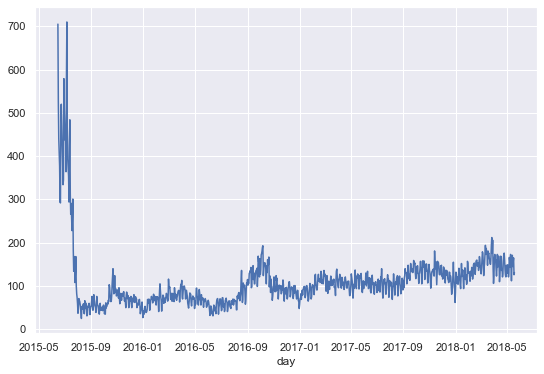

In [15]:
# the number of users who have entered the course
event.groupby("day").user_id.nunique().plot();

In [16]:
users_action = event.pivot_table(index="user_id", 
                  columns="action", 
                  values="step_id", 
                  aggfunc="count", 
                  fill_value=0).reset_index()

In [17]:
users_action.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<AxesSubplot:>

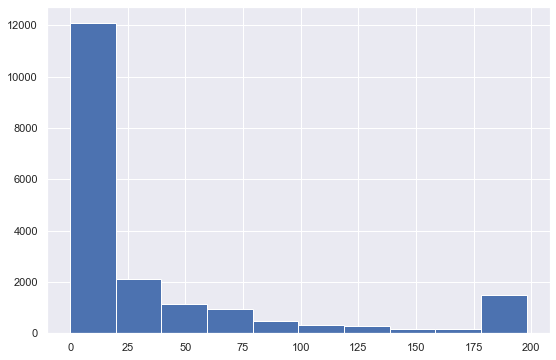

In [18]:
users_action.discovered.hist()

In [19]:
# the number of correct and wrong answers
users_scores = sub.pivot_table(index="user_id", 
                  columns="submission_status", 
                  values="step_id", 
                  aggfunc="count", 
                  fill_value=0).reset_index()

In [20]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [21]:
# calculate for each user the breaks between days
# np.diff returns the difference between two adjacent values in the list
gap_data = event[["user_id", "day", "timestamp"]] \
    .drop_duplicates(subset=["user_id", "day"]) \
    .groupby("user_id")["timestamp"].apply(list) \
    .apply(np.diff).values

In [22]:
# the difference between the closest entrances on the course
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

<AxesSubplot:>

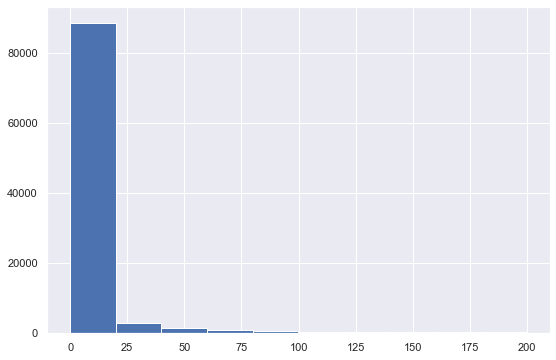

In [23]:
# the difference in days
gap_data_day = gap_data / (24 * 60 * 60)
gap_data_day[gap_data_day < 200].hist()

In [24]:
gap_data.quantile(0.95) / (24 * 60 * 60)

59.760440972222156

In [25]:
gap_data.quantile(0.9) / (24 * 60 * 60)

18.325995370370403

### Therefore, only 5% of users return after a break of 2 months

### We will consider that the person who did not complete the course and did not show up for more than one month has completed the training. 

In [26]:
event.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [27]:
f"from {gap_data.quantile(0.90) / (24 * 60 * 60):.2f} to {gap_data.quantile(0.95) / (24 * 60 * 60):.2f}"

'from 18.33 to 59.76'

In [28]:
# latest date 
now = 1526772811

In [29]:
# month in seconds
month = 30 * 24 * 60 * 60

In [30]:
users_data = event.groupby("user_id", as_index=False) \
    .agg({"timestamp": "max"}).rename(columns={"timestamp": "last_timestamp"})

In [31]:
# if a month has passed since the last visit, the user is considered inactive
users_data["is_gone_user"] = (now - users_data.last_timestamp) > month

In [32]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [33]:
users_data = users_data.merge(users_scores, on="user_id", how="outer")

In [34]:
users_data = users_data.fillna(0)

In [35]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [36]:
event.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [37]:
# the number of unique days during which the user was on the platform
user_days = event.groupby("user_id").day.nunique().to_frame().reset_index()

In [38]:
users_data = users_data.merge(users_action, on="user_id", how="outer")

In [39]:
users_data = users_data.merge(user_days, on="user_id", how="outer")

In [40]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [41]:
users_data.user_id.nunique() == event.user_id.nunique()

True

In [42]:
# create one more column - whether the user has completed the course 
# will consider that completed if user has more than 175 points 
users_data["passed_course"] = users_action.discovered > 175

In [43]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [44]:
users_data.groupby("passed_course").count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17711,17711,17711,17711,17711,17711,17711,17711,17711,17711
True,1523,1523,1523,1523,1523,1523,1523,1523,1523,1523


### it is necessary to check the data for inconsistencies

In [45]:
f"{1523 / 17711 * 100:.1f}%"

'8.6%'

### it's about the industry standard 

### Let's try to predict a student's behavior after three days in the course

<AxesSubplot:>

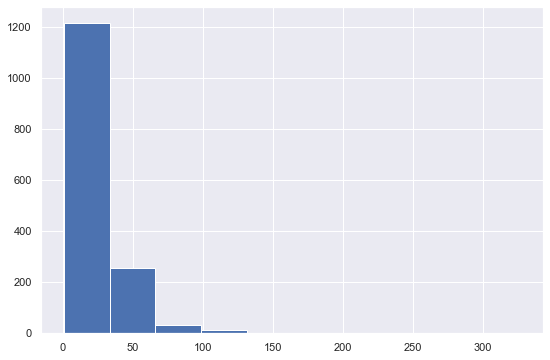

In [46]:
users_data[users_data.passed_course == True].day.hist()

In [47]:
user_start_time = event.groupby("user_id", as_index=False) \
    .agg({"timestamp": "min"}) \
    .rename({"timestamp": "start_timestamp"}, axis=1)

In [48]:
user_start_time.head()

,user_id,start_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [49]:
users_data = users_data.merge(user_start_time[["user_id", "start_timestamp"]], how="outer")

In [50]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,start_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [51]:
three_days = 3 * 24 * 60 * 60

In [52]:
prediction_time = user_start_time.start_timestamp + three_days

In [53]:
user_start_time["prediction_time"] = prediction_time

In [54]:
event.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [55]:
event = event.merge(user_start_time[["user_id", "prediction_time"]], how="outer")

In [56]:
event_train = event[event.timestamp < event.prediction_time]

In [57]:
event_train.head()

,step_id,timestamp,action,user_id,date,day,prediction_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434600048


In [58]:
event_train.groupby("user_id").day.nunique().max()

4

In [59]:
sub.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [60]:
sub = sub.merge(user_start_time[["user_id", "prediction_time"]], how="outer")
sub_train = sub[sub.timestamp < sub.prediction_time]

In [61]:
sub_train.head()

,step_id,timestamp,submission_status,user_id,date,day,prediction_time
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434605177
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,1434605177
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,1434605177


In [62]:
X = sub_train.groupby("user_id").day.nunique().to_frame().reset_index()

In [63]:
total_steps = sub_train.groupby("user_id") \
    .step_id.nunique().to_frame().reset_index() \
    .rename(columns={"step_id": "total_steps"})

In [64]:
X = X.merge(total_steps, on="user_id", how="outer")

In [65]:
response_statistics = sub_train.pivot_table(index="user_id", 
                  columns="submission_status", 
                  values="step_id", 
                  aggfunc="count", 
                  fill_value=0).reset_index()

In [66]:
X = X.merge(response_statistics, on="user_id", how="outer")

In [67]:
X["proportion_correct_answers"] = X.correct / (X.correct + X.wrong)

In [68]:
action_statistics = event_train.pivot_table(index="user_id", 
                  columns="action", 
                  values="step_id", 
                  aggfunc="count", 
                  fill_value=0).reset_index()

In [69]:
X = X.merge(action_statistics[["user_id", "viewed"]], how="outer")

In [70]:
X = X.fillna(0)

In [71]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,start_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [72]:
X = X.merge(users_data[["user_id", "is_gone_user", "passed_course"]], how="outer")

In [73]:
X.shape

(19234, 9)

In [74]:
# we remove users who did not complete the course and left
# the passed_course column shows whether the user left or completed the course
X = X[(X.is_gone_user) | (X.passed_course)]

In [75]:
y = X.passed_course.map(int)

In [76]:
X = X.drop(["passed_course", "is_gone_user"], axis=1)

In [77]:
X = X.set_index("user_id")

In [78]:
X.head()

,day,total_steps,correct,wrong,proportion_correct_answers,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


In [79]:
X.to_csv(r"C:/Users/lemac/AntonProjects/ml/ds_ml_karpov/prepared_data_on_student_outflows/X.csv")

In [81]:
y.to_csv(r"C:/Users/lemac/AntonProjects/ml/ds_ml_karpov/prepared_data_on_student_outflows/y.csv")